# Utilisation de la variable longitude et latitude.

On a crée des variables centre ville pour utiliser la variable longitude et latitude pour déterminer la distance entre le centre ville et la maison.

In [404]:
centre_ville = {"NYC": (40.7128, -74.0060), "SF": (37.7749, -122.4194), "LA": (34.0522, -118.2437),"DC": (38.9072, -77.0369), "Chicago": (41.8781, -87.6298), "Boston": (42.3601, -71.0589),}

In [405]:
def distance_vol_oiseau(ligne):
    city = ligne["city"]
    lat, lon = ligne["latitude"], ligne["longitude"]
    if city not in centre_ville or pd.isnull(lat) or pd.isnull(lon):
        return np.nan
    centre_lat, centre_lon = centre_ville[city]
    R = 6371
    phi1, phi2 = np.radians(lat), np.radians(centre_lat)
    dphi = phi2 - phi1
    dlambda = np.radians(centre_lon - lon)
    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

On applique la fonction a tous le dataframe et on remplace les valeurs manquantes par la moyenne des distances.

In [406]:
airbnb_train["distance_centre"] = airbnb_train.apply(distance_vol_oiseau, axis=1)
airbnb_train["distance_centre"] = airbnb_train["distance_centre"].fillna(airbnb_train["distance_centre"].mean())

# Utilisation et création de nouveaux features

Permet de regrouper le prix selon le zip et de vérifier si elle crée un biais.

In [407]:
airbnb_train["city_zip"] = airbnb_train["city"] + "_" + airbnb_train["zipcode"].astype(str)
airbnb_train["zip_group_price"] = np.nan

On applique une validation croisée pour éviter de donner des informations sur le log_price et ainsi éviter la fuite d'informations sur la variable à prédire.

In [408]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in kf.split(airbnb_train):
    train_data = airbnb_train.iloc[train_idx]
    val_data = airbnb_train.iloc[val_idx]
    means = train_data.groupby("city_zip")["log_price"].mean()
    airbnb_train.iloc[val_idx, airbnb_train.columns.get_loc("zip_group_price")] = val_data["city_zip"].map(means)
airbnb_train["zip_group_price"] = airbnb_train["zip_group_price"].fillna(airbnb_train["log_price"].mean())

Permet de créer de nouvelles variables notamment d'anciennete de l'hote et le nombre de jours depuis sa review.

In [409]:
ref_date = min(airbnb_train["host_since"].min(), airbnb_train["last_review"].min())
airbnb_train["anciennete_hote"] = (ref_date - airbnb_train["host_since"]).dt.days.abs().fillna(0)
airbnb_train["jours_depuis_dernier_avis"] = (ref_date - airbnb_train["last_review"]).dt.days.abs().fillna(0)

Permet de calculer le nombre de personne par lit mais fausse l'apprentissage de l'algorithme. C'est des features qui ne permettent pas à l'algorithme de gagner en précision, il fausse davantage les résultats.

In [410]:
# airbnb_train["bed_density"] = airbnb_train["accommodates"] / airbnb_train["beds"].replace(0, 1)
airbnb_train["room_density"] = airbnb_train["accommodates"] / airbnb_train["bedrooms"].replace(0, 1)

Permet de compter le nombre de mots dans la description.

In [411]:
airbnb_train["desc_length"] = airbnb_train["description"].fillna("").apply(len)
airbnb_train["desc_word_count"] = airbnb_train["description"].fillna("").apply(lambda x: len(x.split()))

Permet de créer des groupes moyens selon le prix.

In [412]:
zipcode_price_mean = airbnb_train.groupby("zipcode")["log_price"].mean()
airbnb_train["zipcode_avg_price"] = airbnb_train["zipcode"].map(zipcode_price_mean)

# Analyse des features

On a globalement davantage de nouveaux features qui donne des informations précieuses pour permettre à l'algorithme de mieux prédire néanmoins certaines features faussent les prédictions.

# Importation en CSV

Permet d'observer les différentes valeurs obtenues sous forme de csv, utile pour visualiser toutes les données

In [413]:
airbnb_train.to_csv("C:/Users/minix/Downloads/Airbnb/test_air3.csv", index=False)

# Prédiction de log_price

On supprime les colonnes inutilisables et on sépare la variable à prédire et les variables explicatives.

In [414]:
y = airbnb_train["log_price"]
X = airbnb_train.drop(columns=["log_price", "id", "name", "property_type", "room_type", "amenities","bed_type", "cancellation_policy", "city", "description","first_review", "last_review", "host_since", "neighbourhood","zipcode", "city_zip","bedrooms"], errors='ignore')

On convertit des booléens en 0 et 1 pour permettre l'utilisation de ces variables.

In [415]:
bool_cols = ["host_has_profile_pic", "host_identity_verified", "instant_bookable", "cleaning_fee"]
for col in bool_cols:
    if col in X.columns and X[col].dtype == "object":
        X[col] = X[col].map({"t": 1, "f": 0, "True": 1, "False": 0})
X = X.fillna(0)

Séparation des variables de test et de train pour le machine learning.

In [416]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
feature_names = X.columns.tolist()

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X.head()

,accommodates,bathrooms,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,number_of_reviews,...,Indoor fireplace,Wide clearance to shower & toilet,distance_centre,zip_group_price,anciennete_hote,jours_depuis_dernier_avis,room_density,desc_length,desc_word_count,zipcode_avg_price
0,3,1.0,False,1.0,0.0,0.0,1,33.782712,-118.134410,0,...,False,False,31.617170,4.210677,2840.0,0.0,3.0,669,118,4.310331
1,4,2.0,False,1.0,1.0,100.0,1,40.705468,-73.909439,38,...,False,False,8.179763,4.213200,3168.0,3485.0,4.0,1000,184,4.231586
2,6,2.0,False,1.0,0.0,0.0,1,38.917537,-77.031651,0,...,False,False,1.235836,5.069614,3205.0,0.0,3.0,494,90,5.060966
3,1,1.0,True,1.0,1.0,100.0,0,40.736001,-73.924248,19,...,False,False,7.356474,4.282217,1615.0,3497.0,1.0,1000,178,4.288450
4,4,1.0,True,1.0,1.0,100.0,0,37.744896,-122.430665,15,...,False,False,3.480175,5.173057,1970.0,3465.0,2.0,1000,172,5.171433


# Test des différents modèles de prédictions.

# Modèle de Régression linéaire multiple

In [417]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
y_train_pred_lr = lr_model.predict(X_train)


rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)


print("Régression Linéaire Multiple")
print(f"Test RMSE : {rmse_lr:.4f}")
print(f"Test R² : {r2_lr:.4f}")

print(f"Score en entrainenement : {r2_score(y_true=y_train, y_pred=y_train_pred_lr)}")
print(f"Score en cross validation : {r2_score(y_true=y_test, y_pred=y_pred_lr)}")

Régression Linéaire Multiple
Test RMSE : 0.4202
Test R² : 0.6553
Score en entrainenement : 0.6664067440062809
Score en cross validation : 0.6552821352246585


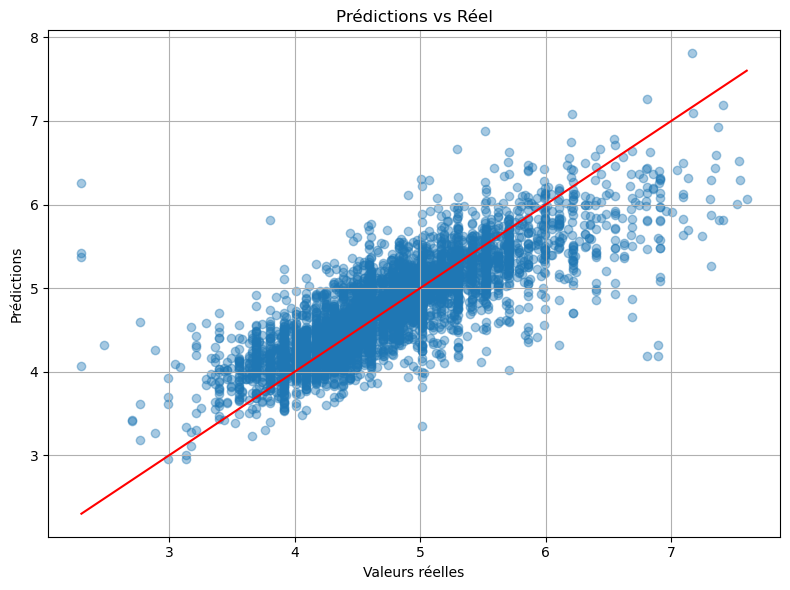

In [418]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Prédictions vs Réel')
plt.grid()
plt.tight_layout()
plt.show()

# Analyse du modèle de régression linéaire multiple

Le modèle de régression linéaire multiple est simple et facile à entraîner permettant d'avoir une bonne baseline linéaire.

Néanmoins cela suppose qu'il y a une relation linéaire entre chaque variable explicative et la variable à prédire et il est très sensible aux outliers et la multicolinéarité.

Donc, il n'est pas adapté dans notre cas puisque les variables ne suivent pas une relation linéaire et de plus on observe beaucoup de outliers comme dans la figure ci-dessus.

# Modèle de Ridge

In [419]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

y_pred_ridge = ridge_model.predict(X_test)
y_train_pred_ridge = ridge_model.predict(X_train)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred))
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Ridge")
print(f"Test RMSE : {rmse_ridge:.4f}")
print(f"Test R²   : {r2_ridge:.4f}")

print(f"Score en entrainenement : {r2_score(y_true=y_train, y_pred=y_train_pred_ridge)}")
print(f"Score en cross validation : {r2_score(y_true=y_test, y_pred=y_pred_ridge)}")

Ridge
Test RMSE : 0.3830
Test R²   : 0.6548
Score en entrainenement : 0.6652157787154955
Score en cross validation : 0.654798763259721


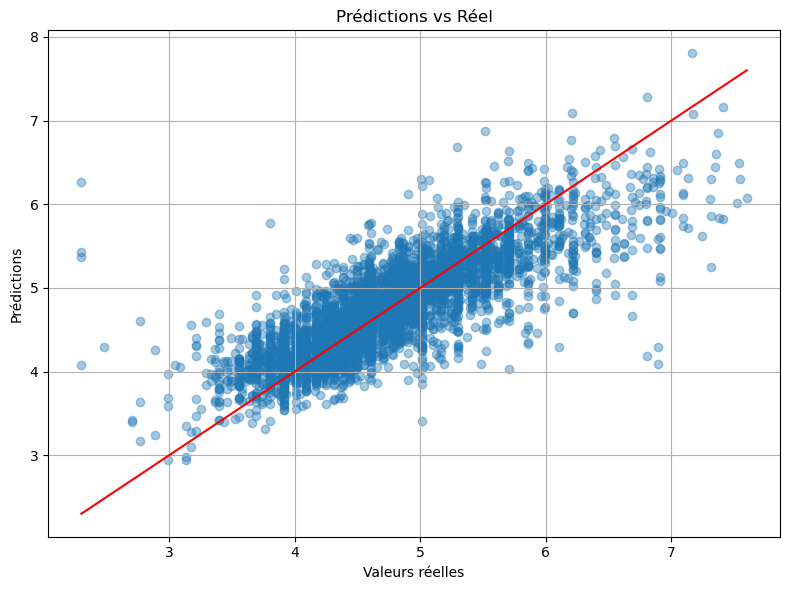

In [420]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ridge, alpha=0.4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Prédictions vs Réel')
plt.grid()
plt.tight_layout()
plt.show()

# Analyse du modèle de Ridge

Le modèle de Ridge gère bien les datasets avec beaucoup de variables, de plus permet de réduire le risque d’overfitting grâce à la régularisation et eeste interprétable (comme la régression linéaire).

Néanmoins, il suppose toujours une relation linéaire entre les variables explicatives et la variable à prédire, il ne sélectionne pas de variables,
et est sensible si les relations sont non linéaire.

Le principal problème est qu'il suppose que les relations sont linéaires néanmoins ce n'est pas le cas de notre prédiction.

# Modèle de Random Forest Regressor

In [421]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_train_pred_rf = rf_model.predict(X_train)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))

print("Random Forest Regressor")
print(f"Test RMSE   : {rmse_rf:.4f}")
print(f"Test R²     : {r2_rf:.4f}")

print(f"Score en entrainenement : {r2_score(y_true=y_train, y_pred=y_train_pred_rf)}")
print(f"Score en cross validation : {r2_score(y_true=y_test, y_pred=y_pred_rf)}")

Random Forest Regressor
Test RMSE   : 0.4083
Test R²     : 0.6746
Score en entrainenement : 0.7949296996775636
Score en cross validation : 0.6745942834843046


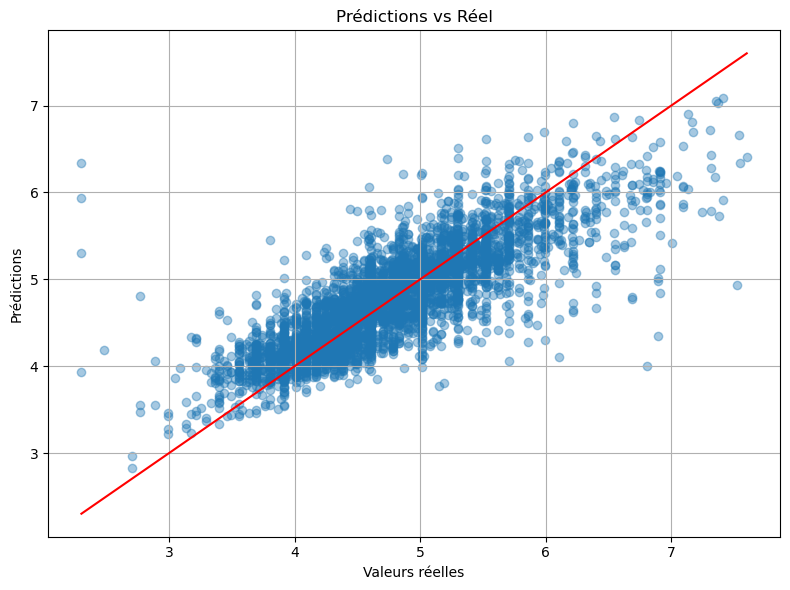

In [422]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Prédictions vs Réel')
plt.grid()
plt.tight_layout()
plt.show()

# Analyse du modèle de Random Forest Regressor

Le modèle gère bien les relations non linéaires complexes, de plus très robuste aux outliers, aux variables non normalisées, et aux interactions tout en donnant une importance à des features claires et surtout est moins sensible à l’overfitting que les arbres seuls.

Néanmoins il est moins interprétable qu’une régression linéaire multiple, il est plus lourd en calcul et mémoire et il peut être plus lent à l’inférence si le modèle est très grand

# Choix final Modèle XGBRegressor

In [423]:
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=-1, num_parallel_tree=None, ...)

Affichage de la racine de la moyenne des erreurs au carrée pour comprendre la différence entre la variable prédite et sa valeur réelle et la courbe de prédiction R².

In [424]:
y_pred = model.predict(X_test)
y_train_pred = rf_model.predict(X_train)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE : {rmse:.4f}")
print(f"R² : {r2:.4f}")

print(f"Score en entrainenement : {r2_score(y_true=y_train, y_pred=y_train_pred)}")
print(f"Score en cross validation : {r2_score(y_true=y_test, y_pred=y_pred)}")

RMSE : 0.3807
R² : 0.7171
Score en entrainenement : 0.7949296996775636
Score en cross validation : 0.7170693100430912


Figure des points réels et de la droite de prédictions pour bien visualiser l'écart.

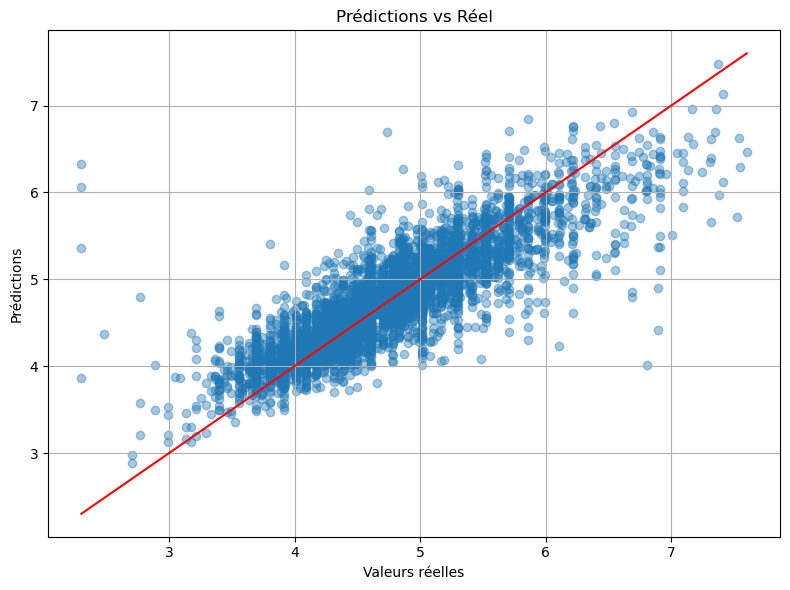

In [425]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Prédictions vs Réel')
plt.grid()
plt.tight_layout()
plt.show()

# Analyse du modèle XGBRegressor

Le modèle donne une précision très élevée, tout en gérant parfaitement les interactions complexes entre variables et tolérant aux données bruitées ou incomplètes, offre une importance des variables fiable.

Cependant, il est moins interprétable que les modèles linéaires et peut surapprendre si les hyperparamètres ne sont pas bien réglés.

# Réglage des paramètres de XGBRegressor

Permet de choisir les meilleurs paramètres d'apprentissages.

In [426]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

xgb_model = XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1)

param_grid = {
    "n_estimators": [100, 300],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",  
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Meilleurs hyperparamètres :", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE avec XGBoost optimisé : {rmse:.4f}")

Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\minix\anaconda3\envs\feux-pietons\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Meilleurs hyperparamètres : {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}
RMSE avec XGBoost optimisé : 0.3830


# Affichage les features les plus importants, ceux qui ont le plus d'impact dans l'apprentissage du modèle.

In [427]:
importances = model.feature_importances_
features = X.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

print("Top features :")
print(feat_imp.head(5))

Top features :
room_type_Private room    0.392883
room_type_Shared room     0.115951
bathrooms                 0.036159
accommodates              0.029675
zipcode_avg_price         0.027306
dtype: float32


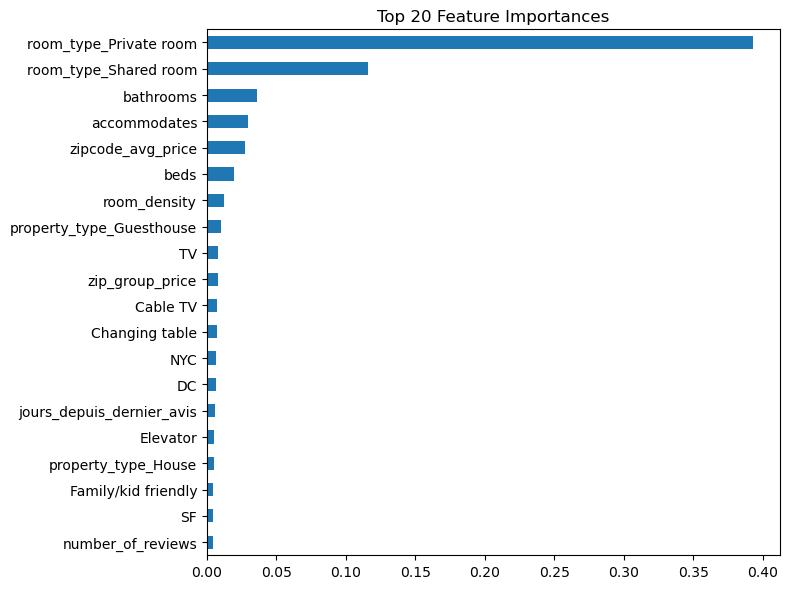

In [428]:
feat_imp.head(20).plot(kind='barh', figsize=(8, 6), title="Top 20 Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Lancement de la prédiction

In [429]:
airbnb_test = pd.read_csv("C:/Users/minix/Downloads/Airbnb/airbnb_test.csv", sep=",")

Prétraitement comme dans la partie 1 de l'analyse des données.

In [430]:
airbnb_test["first_review"] = pd.to_datetime(airbnb_test["first_review"], errors="coerce")
airbnb_test["last_review"] = pd.to_datetime(airbnb_test["last_review"], errors="coerce")
airbnb_test["host_since"] = pd.to_datetime(airbnb_test["host_since"], errors="coerce")
airbnb_test["host_response_rate"] = airbnb_test["host_response_rate"].replace("%", "", regex=True)
airbnb_test["host_response_rate"] = pd.to_numeric(airbnb_test["host_response_rate"], errors='coerce')

In [431]:
airbnb_test = pd.concat([airbnb_test,pd.get_dummies(airbnb_test[["room_type", "cancellation_policy", "property_type", "bed_type"]], drop_first=True),pd.get_dummies(airbnb_test["city"], prefix="city")], axis=1)

In [432]:
amenities_df = pd.DataFrame({amenity: airbnb_test["amenities"].apply(lambda x: amenity in x if pd.notnull(x) else False) for amenity in liste_amenities})

airbnb_test = pd.concat([airbnb_test, amenities_df], axis=1)


In [433]:
airbnb_test["distance_centre"] = airbnb_test.apply(distance_vol_oiseau, axis=1)
airbnb_test["distance_centre"] = airbnb_test["distance_centre"].fillna(airbnb_test["distance_centre"].mean())
airbnb_test = airbnb_test.copy()

In [434]:
airbnb_test["anciennete_hote"] = (ref_date - airbnb_test["host_since"]).dt.days.abs()
airbnb_test["jours_depuis_dernier_avis"] = (ref_date - airbnb_test["last_review"]).dt.days.abs()
airbnb_test["anciennete_hote"] = airbnb_test["anciennete_hote"].fillna(0)
airbnb_test["jours_depuis_dernier_avis"] = airbnb_test["jours_depuis_dernier_avis"].fillna(0)
airbnb_test = airbnb_test.copy()

In [435]:
airbnb_test["room_density"] = airbnb_test["accommodates"] / airbnb_test["bedrooms"].replace(0, 1)
airbnb_test["desc_length"] = airbnb_test["description"].fillna("").apply(len)
airbnb_test["desc_word_count"] = airbnb_test["description"].fillna("").apply(lambda x: len(x.split()))
airbnb_test["zipcode_avg_price"] = airbnb_test["zipcode"].map(zipcode_price_mean)
airbnb_test["city_zip"] = airbnb_test["city"] + "_" + airbnb_test["zipcode"].astype(str)
airbnb_test["zip_group_price"] = airbnb_test["city_zip"].map(airbnb_train.groupby("city_zip")["log_price"].mean())
airbnb_test["zip_group_price"] = airbnb_test["zip_group_price"].fillna(airbnb_train["log_price"].mean())
airbnb_test = airbnb_test.copy()

In [436]:
for col in bool_cols:
    if col in airbnb_test.columns and airbnb_test[col].dtype == "object":
        airbnb_test[col] = airbnb_test[col].map({"t": 1, "f": 0, "True": 1, "False": 0})

In [437]:
for col in feature_names:
    if col not in airbnb_test.columns:
        airbnb_test[col] = 0

In [438]:
airbnb_test = airbnb_test[feature_names]
airbnb_test = airbnb_test.fillna(0)

In [439]:
X_pred = airbnb_test[feature_names]
X_pred_scaled = scaler.transform(X_pred)

In [440]:
log_price_pred = model.predict(X_pred_scaled)
print(log_price_pred)

[4.9419556 5.645757  4.9593163 ... 4.9393487 4.536795  5.5425878]


In [441]:
prediction_example = pd.read_csv("C:/Users/minix/Downloads/Airbnb/prediction_example.csv")
prediction_example["logpred"] = log_price_pred
prediction_example.to_csv("C:/Users/minix/Downloads/Airbnb/MaPredictionFinale.csv", index=False)

In [442]:
def estConforme(monFichier_csv):
    votre_prediction = pd.read_csv(monFichier_csv)

    fichier_exemple = pd.read_csv("C:/Users/minix/Downloads/Airbnb/prediction_example.csv")

    assert votre_prediction.columns[1] == fichier_exemple.columns[1], f"Attention, votre colonne de prédiction doit s'appeler {fichier_exemple.columns[1]}, elle s'appelle '{votre_prediction.columns[1]}'"
    assert len(votre_prediction) == len(fichier_exemple), f"Attention, vous devriez avoir {len(fichier_exemple)} prédiction dans votre fichier, il en contient '{len(votre_prediction)}'"

    assert np.all(votre_prediction.iloc[:,0] == fichier_exemple.iloc[:, 0])

    print("Fichier conforme!")

estConforme("C:/Users/minix/Downloads/Airbnb/MaPredictionFinale.csv")

Fichier conforme!


# Merci